In [1]:
# import libraries
import numpy as np
from sklearn import preprocessing
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
# parameters for CSTR
T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
P = np.array([[1060, 22], [22, 0.52]])
T_s = 402
C_As = 1.95

t_final = 0.005
t_step = 1e-4
num_step = 10
num_dims = 4

# parameters for NN
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 500 # number of epochs of each inner SGD
ntrain = 128 # size of training minibatches (K)
threshold = 10

In [5]:
# functions to vary the parameter values
def generate_new_1000(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_100(x):
    return x + x * np.random.uniform(-1, 1)

def generate_new_5(x):
    return x + x * np.random.uniform(-0.05, 0.05)

In [6]:
# cstr simulation
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        C_A += dCAdt * t_step
        T += dTdt * t_step

        if (i+1)% 5 == 0:
            C_A_list.append(C_A - C_As)
            T_list.append(T - T_s)

    return C_A_list, T_list

# convert numpy array to tensor
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

In [7]:
# generate data around steady state
def gen_cstr_train(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = T_0
        V_new = V
        F_new = F
        C_A0s_new = C_A0s
        Q_s_new = Q_s
        rho_L_new = rho_L
        C_p_new = C_p
        k_0_new = k_0
        E_new = E
        delta_H_new = delta_H

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-0.5, 0.5, 4, endpoint=True)
        u2_list = np.linspace(-5e1, 5e1, 4, endpoint=True)
        T_initial = np.linspace(380, 420, 10, endpoint=True) - T_s
        CA_initial = np.linspace(1.9, 2, 10, endpoint=True) - C_As

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                x = np.array([CA, T])
                if x @ P @ x < 3:
                    CA_start.append(CA)
                    T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [8]:
# generate training data around steady state
isOverflow = True
while isOverflow == True:
    try:
        x_all_train, y_all_train = gen_cstr_train(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

Number of training samples:  160


In [9]:
# generate data in stability region
def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new_100(T_0)
        V_new = generate_new_1000(V)
        F_new = generate_new_1000(F)
        C_A0s_new = generate_new_100(C_A0s)
        Q_s_new = generate_new_1000(Q_s)
        rho_L_new = generate_new_5(rho_L)
        C_p_new = generate_new_5(C_p)
        k_0_new = generate_new_5(k_0)
        E_new = generate_new_5(E)
        delta_H_new = generate_new_5(delta_H)

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-3.5, 3.5, 10, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 10, endpoint=True)
        T_initial = np.linspace(300, 600, 40, endpoint=True) - T_s
        CA_initial = np.linspace(0, 6, 40, endpoint=True) - C_As

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                x = np.array([CA, T])
                if x @ P @ x < 372:
                    CA_start.append(CA)
                    T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2), scaler_X, scaler_y, F_new, V_new, C_A0s_new, T_0_new, Q_s_new

In [10]:
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

Number of training samples:  11800


In [11]:
# check mean and variance of cstr generated
print(scaler_X_cstr.mean_)
print(scaler_X_cstr.var_)
print(scaler_y_cstr.mean_)
print(scaler_y_cstr.var_)

[ 0.86831812 -0.01258149  0.          0.        ]
[1.53825756e+03 7.35427655e-01 1.01851852e+11 4.99074074e+00]
[-5.99795616 -0.07845257]
[1.53269866e+03 7.16817902e-01]


In [12]:
# physics-informed training loop
def train(model, n_epochs, x_collocation):
    optimizer = tf.keras.optimizers.Adam()

    mean_X = to_tensor(scaler_X_cstr.mean_)
    std_X = to_tensor(np.sqrt(scaler_X_cstr.var_))
    mean_y = to_tensor(scaler_y_cstr.mean_)
    std_y = to_tensor(np.sqrt(scaler_y_cstr.var_))

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss1 = K.mean((NN_output[:, :, :] - y[:, :, :])**2)

                NN_output = model(x_collocation)

                CA_NN_input = x_collocation[:, :, 1] * std_X[1] + mean_X[1] + C_As
                T_NN_input = x_collocation[:, :, 0] * std_X[0] + mean_X[0] + T_s
                C_A0 = x_collocation[:, :, 3] * std_X[3] + mean_X[3] + C_A0s_new_cstr
                Q = x_collocation[:, :, 2] * std_X[2] + mean_X[2] + Q_s_new_cstr

                NN_output = NN_output * std_y + mean_y + to_tensor(np.array([T_s, C_As]))

                dCA_first = (NN_output[:, 1:2, 1] - CA_NN_input[:, 0:1]) / (2*t_step*5)
                dT_first = (NN_output[:, 1:2, 0] - T_NN_input[:, 0:1]) / (2*t_step*5)

                dCA_center = (NN_output[:, 2:, 1] - NN_output[:, :-2, 1]) / (2*t_step*5)
                dT_center = (NN_output[:, 2:, 0] - NN_output[:, :-2, 0]) / (2*t_step*5)

                dCA_last = (NN_output[:, -1:, 1] - NN_output[:, -2:-1, 1]) / (t_step*5)
                dT_last = (NN_output[:, -1:, 0] - NN_output[:, -2:-1, 0]) / (t_step*5)

                dCA = K.concatenate((dCA_first, dCA_center, dCA_last), 1)
                dT = K.concatenate((dT_first, dT_center, dT_last), 1)

                lossCA = dCA - F_new_cstr / V_new_cstr * (C_A0 - NN_output[:, :, 1]) + k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]**2
                lossCA = K.mean(lossCA**2)

                lossT = dT - F_new_cstr / V_new_cstr * (T_0_new_cstr - NN_output[:, :, 0]) + delta_H / (rho_L * C_p) * k_0 * K.exp(-E / (R * NN_output[:, :, 0])) * NN_output[:, :, 1]**2 - Q / (rho_L * C_p * V_new_cstr)
                lossT = K.mean(lossT**2)

                loss = 1e3 * loss1 + 1e-2 * lossCA + 1e-5 * lossT

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     if epoch % 100 == 0:
#         print("Training loss: ", loss)

    return model

In [13]:
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

#     if epoch % 100 == 0:
#         print("Training loss: ", loss)

    return model

In [14]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [15]:
# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

No. of collocation points:  1
Testing loss of PI-reptile:  0.01768076978623867
Testing loss of PI:  0.07514599710702896
No. of collocation points:  2
Testing loss of PI-reptile:  0.020817073062062263
Testing loss of PI:  0.059590328484773636
No. of collocation points:  3
Testing loss of PI-reptile:  0.021222759038209915
Testing loss of PI:  0.04895605146884918
No. of collocation points:  4
Testing loss of PI-reptile:  0.020952627062797546
Testing loss of PI:  0.057866550981998444
No. of collocation points:  5
Testing loss of PI-reptile:  0.021518588066101074
Testing loss of PI:  0.04633285105228424
No. of collocation points:  6
Testing loss of PI-reptile:  0.021871859207749367
Testing loss of PI:  0.03406580165028572
No. of collocation points:  7
Testing loss of PI-reptile:  0.022756310179829597
Testing loss of PI:  0.046450935304164886
No. of collocation points:  8
Testing loss of PI-reptile:  0.023064404726028442
Testing loss of PI:  0.036058954894542694
No. of collocation points:  9

Testing loss of PI-reptile:  0.002478495007380843
Testing loss of PI:  0.009141641668975353
No. of collocation points:  69
Testing loss of PI-reptile:  0.002353108022361994
Testing loss of PI:  0.004674521740525961
No. of collocation points:  70
Testing loss of PI-reptile:  0.002479109214618802
Testing loss of PI:  0.005693189799785614
No. of collocation points:  71
Testing loss of PI-reptile:  0.0024840335827320814
Testing loss of PI:  0.006284894421696663
No. of collocation points:  72
Testing loss of PI-reptile:  0.002167165745049715
Testing loss of PI:  0.006869889795780182
No. of collocation points:  73
Testing loss of PI-reptile:  0.0022005559876561165
Testing loss of PI:  0.005217378493398428
No. of collocation points:  74
Testing loss of PI-reptile:  0.0021069119684398174
Testing loss of PI:  0.005734525620937347
No. of collocation points:  75
Testing loss of PI-reptile:  0.0022131362929940224
Testing loss of PI:  0.00497466791421175
No. of collocation points:  76
Testing loss 

In [16]:
# save results
np.savetxt("test_loss_PI_cstr_1_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_1_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

In [17]:
# rerun for 2nd cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_cstr_2_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_2_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of collocation points:  1
Testing loss of PI-reptile:  0.018039368093013763
Testing loss of PI:  0.03399230167269707
No. of collocation points:  2
Testing loss of PI-reptile:  0.015783531591296196
Testing loss of PI:  0.04183343052864075
No. of collocation points:  3
Testing loss of PI-reptile:  0.0162267554551363
Testing loss of PI:  0.05598786845803261
No. of collocation points:  4
Testing loss of PI-reptile:  0.020066428929567337
Testing loss of PI:  0.04104892164468765
No. of collocation points:  5
Testing loss of PI-reptile:  0.020936904475092888
Testing loss of PI:  0.05318213999271393
No. of collocation points:  6
Testing loss of PI-reptile:  0.020857293158769608
Testing loss of PI:  0.06818114966154099
No. of collocation points:  7
Testing loss of PI-reptile:  0.020289601758122444
Testing loss of PI:  0.042646341025829315
No. of collocation points:  8
Testing loss of PI-reptile:  0.020045984536409378
Testing loss of PI:  0.0477264374494552

Testing loss of PI:  0.0052035218104720116
No. of collocation points:  68
Testing loss of PI-reptile:  0.0020321845076978207
Testing loss of PI:  0.005237557925283909
No. of collocation points:  69
Testing loss of PI-reptile:  0.001982674468308687
Testing loss of PI:  0.006989398971199989
No. of collocation points:  70
Testing loss of PI-reptile:  0.002015417907387018
Testing loss of PI:  0.005779080558568239
No. of collocation points:  71
Testing loss of PI-reptile:  0.001893259002827108
Testing loss of PI:  0.00595305860042572
No. of collocation points:  72
Testing loss of PI-reptile:  0.0018411997007206082
Testing loss of PI:  0.007247552741318941
No. of collocation points:  73
Testing loss of PI-reptile:  0.0018357397057116032
Testing loss of PI:  0.005208595190197229
No. of collocation points:  74
Testing loss of PI-reptile:  0.0018336600624024868
Testing loss of PI:  0.004126395098865032
No. of collocation points:  75
Testing loss of PI-reptile:  0.0017945856088772416
Testing los

In [18]:
# rerun for 3rd cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_cstr_3_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_3_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of collocation points:  1
Testing loss of PI-reptile:  0.016939371824264526
Testing loss of PI:  0.055453065782785416
No. of collocation points:  2
Testing loss of PI-reptile:  0.016166534274816513
Testing loss of PI:  0.043426115065813065
No. of collocation points:  3
Testing loss of PI-reptile:  0.015506480820477009
Testing loss of PI:  0.04905411973595619
No. of collocation points:  4
Testing loss of PI-reptile:  0.017565637826919556
Testing loss of PI:  0.029302963986992836
No. of collocation points:  5
Testing loss of PI-reptile:  0.018331430852413177
Testing loss of PI:  0.043368276208639145
No. of collocation points:  6
Testing loss of PI-reptile:  0.017267201095819473
Testing loss of PI:  0.0400535874068737
No. of collocation points:  7
Testing loss of PI-reptile:  0.016586096957325935
Testing loss of PI:  0.03875357285141945
No. of collocation points:  8
Testing loss of PI-reptile:  0.017276037484407425
Testing loss of PI:  0.069257594645

Testing loss of PI:  0.005623084958642721
No. of collocation points:  68
Testing loss of PI-reptile:  0.002335923258215189
Testing loss of PI:  0.006142788100987673
No. of collocation points:  69
Testing loss of PI-reptile:  0.002272506942972541
Testing loss of PI:  0.005719345062971115
No. of collocation points:  70
Testing loss of PI-reptile:  0.0023272621911019087
Testing loss of PI:  0.004878384992480278
No. of collocation points:  71
Testing loss of PI-reptile:  0.0021696840412914753
Testing loss of PI:  0.005233830772340298
No. of collocation points:  72
Testing loss of PI-reptile:  0.0021712067537009716
Testing loss of PI:  0.0055106221698224545
No. of collocation points:  73
Testing loss of PI-reptile:  0.002297429833561182
Testing loss of PI:  0.007051325403153896
No. of collocation points:  74
Testing loss of PI-reptile:  0.0022037711460143328
Testing loss of PI:  0.006806458346545696
No. of collocation points:  75
Testing loss of PI-reptile:  0.0022306034807115793
Testing lo

In [31]:
# rerun for 4th cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_cstr_4_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_4_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of collocation points:  1
Testing loss of PI-reptile:  0.01742994226515293
Testing loss of PI:  0.04207294434309006
No. of collocation points:  2
Testing loss of PI-reptile:  0.018653227016329765
Testing loss of PI:  0.03766448423266411
No. of collocation points:  3
Testing loss of PI-reptile:  0.01952839083969593
Testing loss of PI:  0.03643826022744179
No. of collocation points:  4
Testing loss of PI-reptile:  0.01958167552947998
Testing loss of PI:  0.05738893523812294
No. of collocation points:  5
Testing loss of PI-reptile:  0.021355248987674713
Testing loss of PI:  0.041335877031087875
No. of collocation points:  6
Testing loss of PI-reptile:  0.020384367555379868
Testing loss of PI:  0.050287678837776184
No. of collocation points:  7
Testing loss of PI-reptile:  0.02085581235587597
Testing loss of PI:  0.06669116020202637
No. of collocation points:  8
Testing loss of PI-reptile:  0.02043980360031128
Testing loss of PI:  0.07188629359006882


Testing loss of PI:  0.007454381324350834
No. of collocation points:  68
Testing loss of PI-reptile:  0.002463150303810835
Testing loss of PI:  0.005087518133223057
No. of collocation points:  69
Testing loss of PI-reptile:  0.0025154384784400463
Testing loss of PI:  0.005463165696710348
No. of collocation points:  70
Testing loss of PI-reptile:  0.0024333749897778034
Testing loss of PI:  0.005260256119072437
No. of collocation points:  71
Testing loss of PI-reptile:  0.00231880322098732
Testing loss of PI:  0.006589570548385382
No. of collocation points:  72
Testing loss of PI-reptile:  0.002227998338639736
Testing loss of PI:  0.009501069784164429
No. of collocation points:  73
Testing loss of PI-reptile:  0.0021874387748539448
Testing loss of PI:  0.006227443926036358
No. of collocation points:  74
Testing loss of PI-reptile:  0.002137156669050455
Testing loss of PI:  0.005800133105367422
No. of collocation points:  75
Testing loss of PI-reptile:  0.0020991472993046045
Testing loss 

In [20]:
# rerun for 5th cstr
# generate cstr data in stability region
isOverflow = True
while isOverflow == True:
    try:
        x_all, y_all, scaler_X_cstr, scaler_y_cstr, F_new_cstr, V_new_cstr, C_A0s_new_cstr, T_0_new_cstr, Q_s_new_cstr = gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

# prepare testing data
batch_size = len(x_all)
test_dataset = tf.data.Dataset.from_tensor_slices((x_all, y_all))
test_dataset = test_dataset.batch(batch_size)

# 10-shot learning on unseen task wrt 500 epochs per shot
num_shots = 100
test_loss_PI = np.zeros(num_shots)
test_loss_PI_reptile = np.zeros(num_shots)

# prepare training data
seed = 0
rng = np.random.RandomState(seed)
sample_idx = rng.choice(len(x_all), size=10)
x_train = x_all[sample_idx]
y_train = y_all[sample_idx]

for i in range(num_shots):

    print("No. of collocation points: ", i+1)

    # prepare collocation data
    seed = 0
    rng = np.random.RandomState(seed)
    sample_idx = rng.choice(len(x_all), size=i+1)
    x_collocation = x_all[sample_idx]
    x_collocation = to_tensor(x_collocation)

    batch_size = 256
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=256).batch(batch_size)

    # initialize model for PI-reptile
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))
    model = pickle.load(open('model_reptile_cstr_batch_pfr.sav', 'rb'))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI_reptile[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI-reptile: ", test_loss_PI_reptile[i])

    # initialize model for PI
    model = Model()
    _ = model(tf.zeros((ntrain, num_step, 4)))

    n_epochs = 500
    model = train(model, n_epochs, x_collocation)

    for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
        NN_output = model(x_batch)
        y_batch = tf.cast(y_batch, tf.float32)
        test_loss_PI[i] = tf.reduce_mean((NN_output - y_batch)**2)

    print("Testing loss of PI: ", test_loss_PI[i])

# save results
np.savetxt("test_loss_PI_cstr_5_time.txt", test_loss_PI, fmt='%f', delimiter=" ")
np.savetxt("test_loss_PI_reptile_cstr_5_time.txt", test_loss_PI_reptile, fmt='%f', delimiter=" ")

Number of training samples:  11800
No. of collocation points:  1
Testing loss of PI-reptile:  0.017315229400992393
Testing loss of PI:  0.07539136707782745
No. of collocation points:  2
Testing loss of PI-reptile:  0.01577702723443508
Testing loss of PI:  0.046742673963308334
No. of collocation points:  3
Testing loss of PI-reptile:  0.016872147098183632
Testing loss of PI:  0.06187140941619873
No. of collocation points:  4
Testing loss of PI-reptile:  0.018646016716957092
Testing loss of PI:  0.05287724733352661
No. of collocation points:  5
Testing loss of PI-reptile:  0.01907000131905079
Testing loss of PI:  0.063301682472229
No. of collocation points:  6
Testing loss of PI-reptile:  0.017897700890898705
Testing loss of PI:  0.04121210426092148
No. of collocation points:  7
Testing loss of PI-reptile:  0.018214141950011253
Testing loss of PI:  0.05365131050348282
No. of collocation points:  8
Testing loss of PI-reptile:  0.018984932452440262
Testing loss of PI:  0.048237740993499756

Testing loss of PI:  0.005423946771770716
No. of collocation points:  68
Testing loss of PI-reptile:  0.002468323800712824
Testing loss of PI:  0.005915622226893902
No. of collocation points:  69
Testing loss of PI-reptile:  0.002368700923398137
Testing loss of PI:  0.0065277679823338985
No. of collocation points:  70
Testing loss of PI-reptile:  0.0023686490021646023
Testing loss of PI:  0.005981677211821079
No. of collocation points:  71
Testing loss of PI-reptile:  0.002303461544215679
Testing loss of PI:  0.006755235604941845
No. of collocation points:  72
Testing loss of PI-reptile:  0.002299986081197858
Testing loss of PI:  0.005331740248948336
No. of collocation points:  73
Testing loss of PI-reptile:  0.0022866881918162107
Testing loss of PI:  0.005143375135958195
No. of collocation points:  74
Testing loss of PI-reptile:  0.002397016854956746
Testing loss of PI:  0.007002095226198435
No. of collocation points:  75
Testing loss of PI-reptile:  0.0022915329318493605
Testing loss

In [2]:
# get mean and std
test_loss_PI_cstr_1 = np.loadtxt("test_loss_PI_cstr_1_time.txt")
test_loss_PI_cstr_2 = np.loadtxt("test_loss_PI_cstr_2_time.txt")
test_loss_PI_cstr_3 = np.loadtxt("test_loss_PI_cstr_3_time.txt")
test_loss_PI_cstr_4 = np.loadtxt("test_loss_PI_cstr_4_time.txt")
test_loss_PI_cstr_5 = np.loadtxt("test_loss_PI_cstr_5_time.txt")

test_loss_PI_cstr_mean = np.mean((test_loss_PI_cstr_1, test_loss_PI_cstr_2, test_loss_PI_cstr_3, test_loss_PI_cstr_4, test_loss_PI_cstr_5), axis=0)
test_loss_PI_cstr_std = np.std((test_loss_PI_cstr_1, test_loss_PI_cstr_2, test_loss_PI_cstr_3, test_loss_PI_cstr_4, test_loss_PI_cstr_5), axis=0)

test_loss_PI_reptile_cstr_1 = np.loadtxt("test_loss_PI_reptile_cstr_1_time.txt")
test_loss_PI_reptile_cstr_2 = np.loadtxt("test_loss_PI_reptile_cstr_2_time.txt")
test_loss_PI_reptile_cstr_3 = np.loadtxt("test_loss_PI_reptile_cstr_3_time.txt")
test_loss_PI_reptile_cstr_4 = np.loadtxt("test_loss_PI_reptile_cstr_4_time.txt")
test_loss_PI_reptile_cstr_5 = np.loadtxt("test_loss_PI_reptile_cstr_5_time.txt")

test_loss_PI_reptile_cstr_mean = np.mean((test_loss_PI_reptile_cstr_1, test_loss_PI_reptile_cstr_2, test_loss_PI_reptile_cstr_3, test_loss_PI_reptile_cstr_4, test_loss_PI_reptile_cstr_5), axis=0)
test_loss_PI_reptile_cstr_std = np.std((test_loss_PI_reptile_cstr_1, test_loss_PI_reptile_cstr_2, test_loss_PI_reptile_cstr_3, test_loss_PI_reptile_cstr_4, test_loss_PI_reptile_cstr_5), axis=0)

In [3]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

meta NOT subset; don't know how to subset; dropped


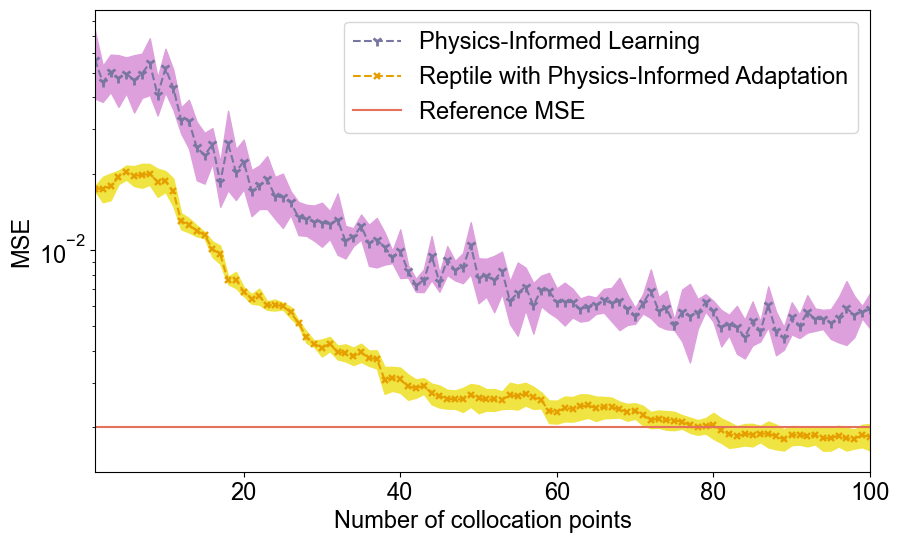

In [23]:
# Testing
test_loss_reference = [0.002]

size = 100
x = np.arange(1,size+1,1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)

plt.plot(x, test_loss_PI_cstr_mean[:size], '--', color='#7976A2', marker='1', linewidth=1.5, markersize=7.5, markeredgewidth=2, label='Physics-Informed Learning')
plt.fill_between(x, test_loss_PI_cstr_mean[:size] - test_loss_PI_cstr_std[:size], test_loss_PI_cstr_mean[:size] + test_loss_PI_cstr_std[:size], edgecolor="plum", facecolor="plum")

plt.plot(x, test_loss_PI_reptile_cstr_mean[:size], '--', color='#E69F00', marker='x', linewidth=1.5, markersize=5, markeredgewidth=1.75, label='Reptile with Physics-Informed Adaptation')
plt.fill_between(x, test_loss_PI_reptile_cstr_mean[:size] - test_loss_PI_reptile_cstr_std[:size], test_loss_PI_reptile_cstr_mean[:size] + test_loss_PI_reptile_cstr_std[:size], edgecolor="#F0E442", facecolor="#F0E442")

plt.plot(x, test_loss_reference*(size), color='#E47159', linewidth=1.5, label='Reference MSE')

plt.legend()
plt.xlabel("Number of collocation points")
plt.ylabel("MSE")
plt.margins(x=0)
plt.yscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('cstr_time.pdf')
plt.show()